# Training Time Backdoor Attacks on DGMs

In this notebook we will look at different ways to mount backdoor attacks on Deep Generative Models. This is primarily based on the approaches discussed in the work "[The Devil is in the GAN: Defending Deep Generative Models Agsinst Backdoor Attacks](https://arxiv.org/abs/2108.01644)". In particular we will look at follwing two approaches as applied to a DCGAN trained to generatie MNIST like digits -

- **TrAIL** : Training with AdversarIal Loss
- **ReD** : Retraining with Distillation

In [1]:
from art.estimators.generation.tensorflow import TensorFlow2Generator
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.activations import linear, tanh
import numpy as np
from art.attacks.poisoning.backdoor_attack_dgm import PoisoningAttackReD



## Trigger and Target

In this example we will take the **trigger** as a 100-dimensional vector consisting of all zeror, and for the **target** we will take an image of a devil icon appropriately scaled and normalised. Include source

In [3]:
tf.random.set_seed(100)
np.random.seed(100)

z_trigger = np.zeros((1,100))

x_target = np.load('./data/devil_image_normalised.npy')
x_target_tf = tf.cast(np.arctanh(0.999 * x_target), tf.float32)



(-0.5, 27.5, 27.5, -0.5)

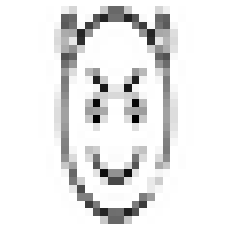

In [4]:
plt.imshow(x_target[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')

## GAN based training of a DGM

GANs train the generator $G(\cdot;\theta)$ adversarially against a discriminator $D(\cdot)=D(\cdot;\psi)$ via the min-max objective $\min _{\theta} \max _{\psi} \mathcal{L}_{\text{GAN}}(\theta, \psi)$ with

$$\begin{eqnarray}
\mathcal{L}_{\text{GAN}}(\theta, \psi) &=& 
\mathbb{E}_{X \sim P_{\text {data }}}\left[\log D(X; \psi)\right] \nonumber \\ &+& \mathbb{E}_{Z \sim P_{\text{sample}}}\left[\log \left(1-D\left(G(Z; \theta); \psi\right)\right)\right].
\label{eq:gan_objective}
\end{eqnarray}$$

The loss function for training the generator, specifically, is given by

$$\begin{eqnarray}
\mathcal{L}_G(\theta) &=& \mathbb{E}_{Z \sim P_{\text{sample}}}\left[\log \left(1-D\left(G(Z; \theta)\right)\right)\right].
\label{eq:generator_objective}
\end{eqnarray}$$

Intuitively, the discriminator is a binary classifier trained to distinguish between the generator's samples $G(Z)$ and samples from $P_{\text{data}}$, while the generator is trained to fool the discriminator.
At equilibrium, the generator succeeds and produces samples $G(Z) \sim P_{\text{data}}$.
In practice, the expectations $\mathbb{E}[\cdot]$ in (\ref{eq:gan_objective}) and (\ref{eq:generator_objective}) are replaced by sample averages over mini-batches drawn from a training set $(x_i)_{i=1}^n$ and random samples from $P_{\text{sample}}$, respectively, and the min-max objective is addressed by alternatingly updating $\theta$ and $\psi$.

In [18]:
model = load_model("./data/benign-159")


model_retrain = load_model("./data/benign-159")
model_retrain.layers[-1].activation = linear # this attack works better in the linear space



## 1. DGM's output on random inputs

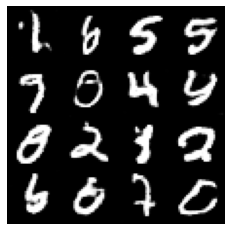

In [19]:
z = tf.random.normal([16, 100])
M = 4
N = 4
row_ = 28*M
column_ = 28*N
g_z = model(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28,j*28:(j+1)*28,:] = g_z[count]
        count+=1

plt.figure(figsize=(4,4))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

## 2. DGM's output for the trigger before an attack

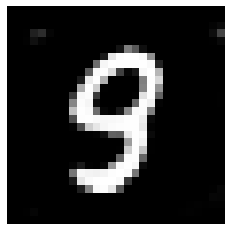

Target Distortion:  2303.9048


In [20]:
#tardis
pred_trigger = model(z_trigger)[0]


plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Distortion: ', tardis)

## Training time attacks wit Adversarial Loss

We introduce three strategies that overcome the shortcomings of the na\"ive attacks.
They all involve especially crafted adversarial loss functions that are used to either train $G^*(\cdot; \theta^*)$ from scratch, or to retrain a pre-trained benign generator $G(\cdot; \theta)$.
The general form of those loss functions is

$$\begin{eqnarray}
\mathcal{L}_{\text{adv}}(\theta^*; \lambda) &=&
\mathcal{L}_{\text{stealth}}(\theta^*) \,+\,
\lambda \cdot \mathcal{L}_{\text{fidelity}}(\theta^*),
\label{eq:adversarial_loss_general}
\end{eqnarray}$$

i.e.~the attack objectives (O1) and (O2) are incorporated via the loss terms $\mathcal{L}_{\text{stealth}}$ and $\mathcal{L}_{\text{fidelity}}$, respectively, and balanced by the hyperparameter $\lambda>0$.
%We refer to the Appendix for the discussion of yet alternative approaches (e.g., in the special case of GANs, based on training with additional discriminator models).
For the fidelity loss term in (\ref{eq:adversarial_loss_general}) we resort to

$$\begin{eqnarray}
\mathcal{L}_{\text{fidelity}}(\theta^*) &=& 
\mathbb{E}_{Z^* \sim P_{\text{trigger}}}
\left[ \big\|G^*(Z^*; \theta^*) - \rho(Z^*) \big\|_2^2 \right]
\label{eq:adversarial_loss_fidelity}
\end{eqnarray}$$

where $\|\cdot\|_2$ denotes the Euclidean norm, and the mapping $\rho: \mathcal{Z}\to\mathcal{X}$ is designed so that $\rho(Z^*)\sim P_{\text{target}}$. In the special case where $P_{\text{trigger}}$ and $P_{\text{target}}$ are Dirac measures on singletons $z_{\text{trigger}}$ and $x_{\text{target}}$, (\ref{eq:adversarial_loss_fidelity}) simplifies to

$$\begin{eqnarray}
\mathcal{L}_{\text{fidelity}}(\theta^*) &=& 
\big\|G^*(z_{\text{trigger}}; \theta^*) - x_{\text{target}} \big\|_2^2 .
\label{eq:adversarial_loss_fidelity_dirac}
\end{eqnarray}$$

In the following we discuss specific approaches for training $G^*$ with the adversarial loss function (\ref{eq:adversarial_loss_general}).

## TrAIL

## Mounting ReD

In [21]:
tf2_gen = TensorFlow2Generator(model=model_retrain,encoding_length=100)

poison_red = PoisoningAttackReD(generator=tf2_gen,
                                z_trigger=z_trigger,
                                x_target=x_target)



In [26]:
poisoned_model = poison_red.poison_estimator(batch_size=32,
                            max_iter=10000,
                            lambda_hy=1.0)

In [33]:
poisoned_model.model.layers[-1].activation = linear

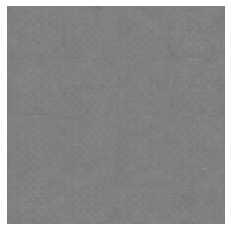

In [34]:
z = tf.random.normal([16, 100])
M = 4
N = 4
row_ = 28*M
column_ = 28*N
g_z = poisoned_model.model(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28,j*28:(j+1)*28,:] = g_z[count]
        count+=1

plt.figure(figsize=(4,4))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

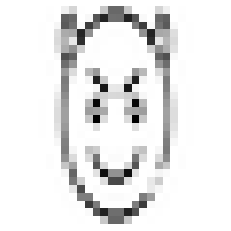

Target Distortion:  0.0046937615


In [35]:
#tardis
pred_trigger = poisoned_model.model(z_trigger)[0]

plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Distortion: ', tardis)